In [7]:
%matplotlib inline
import nhl_search
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nhl_dictionaries as nhl_dicts
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
plt.rcParams['figure.figsize'] = (14,10)

## How to build sabermetrics databases

We will use Andrew Tan's `nhl_search.py` script to create databases.  This notebook is based on an example he provided and most of the comments are taken directly from it.

To start we initialize the databases. The NHLSearch object contains all the data from the game and player databases. By default it will assume the data bases: `gameDataBase.csv` and `playerDataBase.csv` are located in the current directory. However the user may specify their own databases during initialization.

In [8]:
nhl_data = nhl_search.NHLSearch()
nhl_data

<nhl_search.NHLSearch instance at 0x7f6096f143f8>

In [9]:
# access the game database
gameDataBase = nhl_data.gameDB
print gameDataBase.head()

               Away  Away On Net  Away Score  Away Shots  Corsi        Date  \
ID                                                                            
20141008MTLTOR  MTL           28           4          54      0  2014/10/08   
20141008PHIBOS  PHI           19           1          43    -13  2014/10/08   
20141008VANCGY  VAN           29           4          46      3  2014/10/08   
20141008S.JL.A  S.J           26           4          54    -14  2014/10/08   
20141009COLBUF  COL            0           3           0    -38  2014/10/09   

               Home  Home On Net  Home Score  Home Shots Season  
ID                                                               
20141008MTLTOR  TOR           34           3          54  14/15  
20141008PHIBOS  BOS           41           2          56  14/15  
20141008VANCGY  CGY           30           2          43  14/15  
20141008S.JL.A  L.A           53           0          68  14/15  
20141009COLBUF  BUF           32           1      

Both data bases are contained in the `Pandas` dataframe container. One must become familiar with this data object in order to successfully perform a search. In this simple example I'll search for all the games in the 14/15 season. The result of the search are the unique `ID`s of each game which are set as the `index` of each entry of the dataframe.

In [10]:
seasonGames = gameDataBase.loc[gameDataBase.Season=='14/15']
gameIDs = seasonGames.index
gameIDs

Index([u'20141008MTLTOR', u'20141008PHIBOS', u'20141008VANCGY',
       u'20141008S.JL.A', u'20141009COLBUF', u'20141009N.JPHI',
       u'20141009ANAPIT', u'20141009MTLWSH', u'20141009BOSDET',
       u'20141009FLAT.B',
       ...
       u'20150523ANACHI', u'20150525CHIANA', u'20150527ANACHI',
       u'20150530CHIANA', u'20150603CHIT.B', u'20150606CHIT.B',
       u'20150608T.BCHI', u'20150610T.BCHI', u'20150613CHIT.B',
       u'20150615T.BCHI'],
      dtype='object', name=u'ID', length=1319)

With the `ID`s we can mutate each of them into a `Game` object using the `GetGames` method. This outputs a list containing `Game` objects. Each game object contains the following attributes: `playbyplay`, `date`, `away`, `home`, `awayscore`, `homescore` as well as the team rosters in `awayteam` and `hometeam`.

In [11]:
games = nhl_search.GetGames(gameIDs)
games[:10] # looking at the first 10

[<nhl_search.Game instance at 0x7f60762c00e0>,
 <nhl_search.Game instance at 0x7f60b69cb680>,
 <nhl_search.Game instance at 0x7f609c15e908>,
 <nhl_search.Game instance at 0x7f6079140ef0>,
 <nhl_search.Game instance at 0x7f60762bdc20>,
 <nhl_search.Game instance at 0x7f60762a92d8>,
 <nhl_search.Game instance at 0x7f60762a99e0>,
 <nhl_search.Game instance at 0x7f6076a5cb00>,
 <nhl_search.Game instance at 0x7f6076a5cd88>,
 <nhl_search.Game instance at 0x7f60781746c8>]

In [12]:
games[0].playbyplay.head() # what the playbyplay dataframe looks like

,Period,STR,Game-Time,Event,Team,Acting Player,Recieving Player,Location,slot1,slot2,...,Away on Ice 5,Away on Ice 6,Home on Ice 1,Home on Ice 2,Home on Ice 3,Home on Ice 4,Home on Ice 5,Home on Ice 6,Away Team,Home Team
Event Number,,,,,,,,,,,,,,,,,,,,,
1,1,,20:00,10,0,0,0,0,0,0,...,76,31,42,81,21,3,12,45,MTL,TOR
2,1,0,20:00,4,0,51,42,1,0,0,...,76,31,42,81,21,3,12,45,MTL,TOR
3,1,0,19:41,7,0,51,0,3,41,1,...,76,31,42,81,21,3,12,45,MTL,TOR
4,1,0,19:24,13,1,81,74,2,0,0,...,76,31,42,81,21,46,50,45,MTL,TOR
5,1,0,19:13,1,1,42,0,3,46,6,...,79,31,42,81,21,46,50,45,MTL,TOR


In [13]:
nhl_dicts.events['SHOT'] # events is a dictionary that translates labels

'1'

In [14]:
# here we create a new dataframe including only shot distances
df = games[0].playbyplay
shots = df.loc[df.Event == nhl_dicts.events['SHOT'] , ['slot1']]
shots.columns = ['Shot distance']
shots.head()

,Shot distance
Event Number,
5,46
10,59
19,24
26,47
30,32


In [15]:
print("number of games found = %d" %len(games))

number of games found = 1319


Now our objective is to collect distance and shot types from each game and compile it into one dataframe. 

In [155]:
def ShotAnalysis(game):
    #Get play by play data from game object
    df = game.playbyplay
    #Subset for shots on net, misses and goals.
    df_shots = df.loc[(df.Event =='1') | (df.Event == '2')| (df.Event =='7'),['Event','slot1','slot2']]
    return df_shots

In [17]:
# test the function on just one game
ShotAnalysis(games[0])

,Event,slot1,slot2
Event Number,,,
3,7,41,1
5,1,46,6
10,1,59,1
11,7,19,3
18,7,60,1
19,1,24,3
26,1,47,1
30,1,32,1
37,7,22,1


In [179]:
# run the function for all games
shotdata = pd.concat(map(ShotAnalysis,games))
shotdata.columns = ['Event','Distance','Shot'] 
print(len(shotdata))
shotdata.head(100)

110922


,Event,Distance,Shot
Event Number,,,
3,7,41,1
5,1,46,6
10,1,59,1
11,7,19,3
18,7,60,1
19,1,24,3
26,1,47,1
30,1,32,1
37,7,22,1


In [157]:
##Use the dictionaries to translate the data:
shotdata.Event = [nhl_dicts.inv_events[i] for i in shotdata['Event']]
shotdata.Shot = [nhl_dicts.inv_shotTypes[i] for i in shotdata['Shot']]
shotdata.head()

,Event,Distance,Shot
Event Number,,,
3,MISS,41,Wrist
5,SHOT,46,Backhand
10,SHOT,59,Wrist
11,MISS,19,Snap
18,MISS,60,Wrist


In [20]:
nhl_dicts.inv_events

{'0': 'Unknown',
 '1': 'SHOT',
 '10': 'PSTR',
 '11': 'PEND',
 '12': 'GEND',
 '13': 'BLOCK',
 '14': 'SOC',
 '15': 'GOFF',
 '2': 'GOAL',
 '3': 'STOP',
 '4': 'FAC',
 '5': 'HIT',
 '6': 'PENL',
 '7': 'MISS',
 '8': 'TAKE',
 '9': 'GIVE'}

In [21]:
nhl_dicts.inv_shotTypes

{'0': 'Unknown',
 '1': 'Wrist',
 '2': 'Slap',
 '3': 'Snap',
 '4': 'Wrap-around',
 '5': 'Tip-In',
 '6': 'Backhand'}

In [22]:
print(len(shotdata))

110922


In [159]:
# put all the misses into a list
all_miss_distances = [int(shotdata.iloc[i,1]) for i in range(len(shotdata))
                  if shotdata.iloc[i,0] == 'MISS']
print(len(all_miss_distances))
all_miss_distances[:10]

30887


[41, 19, 60, 22, 27, 26, 53, 57, 37, 50]

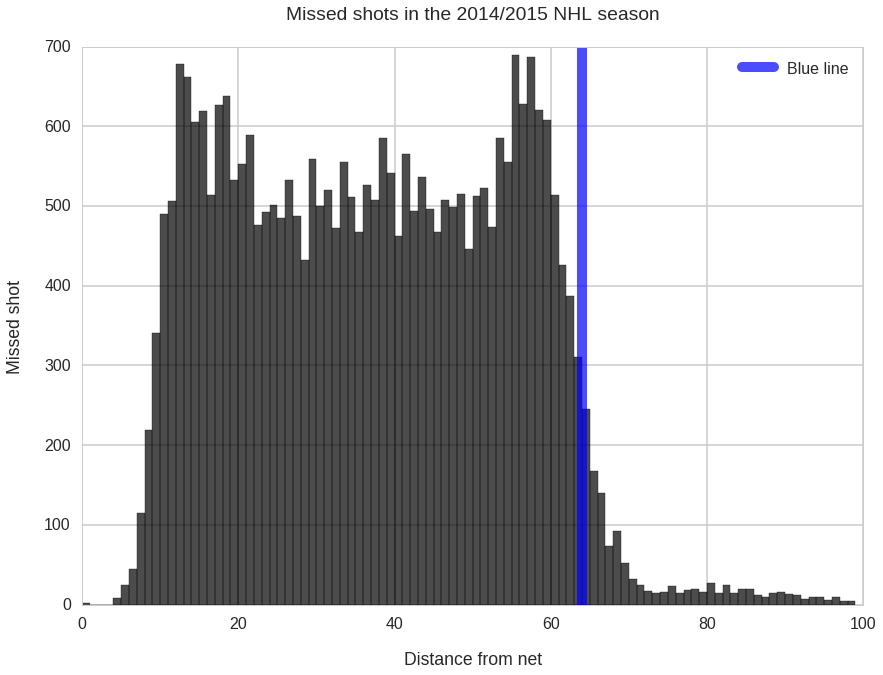

In [24]:
# plot the list as a histogram
plt.hist(all_miss_distances, bins=np.arange(0,100,1), color='black', alpha=0.7)
plt.title("Missed shots in the 2014/2015 NHL season", y=1.04)
plt.xlabel("Distance from net", labelpad=20)
plt.ylabel("Missed shots", labelpad=20)
plt.axvline(64,0,1000,color='b', label='Blue line', alpha=0.7, linewidth=10)
plt.legend()

In [25]:
# from here on out I don't bother translating and use event labels instead
nhl_dicts.inv_events

{'0': 'Unknown',
 '1': 'SHOT',
 '10': 'PSTR',
 '11': 'PEND',
 '12': 'GEND',
 '13': 'BLOCK',
 '14': 'SOC',
 '15': 'GOFF',
 '2': 'GOAL',
 '3': 'STOP',
 '4': 'FAC',
 '5': 'HIT',
 '6': 'PENL',
 '7': 'MISS',
 '8': 'TAKE',
 '9': 'GIVE'}

In [26]:
games[0].playbyplay.columns

Index([u'Period', u'STR', u'Game-Time', u'Event', u'Team', u'Acting Player',
       u'Recieving Player', u'Location', u'slot1', u'slot2', u'slot3',
       u'slot4', u'Away on Ice 1', u'Away on Ice 2', u'Away on Ice 3',
       u'Away on Ice 4', u'Away on Ice 5', u'Away on Ice 6', u'Home on Ice 1',
       u'Home on Ice 2', u'Home on Ice 3', u'Home on Ice 4', u'Home on Ice 5',
       u'Home on Ice 6', u'Away Team', u'Home Team'],
      dtype='object')

Now we'll filter information from the dataframe for specific players without using the player database.

In [187]:
def ShotAnalysis(game):
    #Get play by play data from game object
    df = game.playbyplay
    #Subset for shots on net, misses and goals.
    df_shots = df.loc[(df.Event =='1') | (df.Event == '2')| (df.Event =='7'),
                      ['Event','slot1','slot2','Acting Player','Team','Away Team',
                       'Away on Ice 1','Away on Ice 2','Away on Ice 3','Away on Ice 4',
                       'Away on Ice 5','Home Team','Home on Ice 1','Home on Ice 2',
                       'Home on Ice 3','Home on Ice 4','Home on Ice 5']]
    return df_shots

In [28]:
ShotAnalysis(games[0]).head()

,Event,slot1,slot2,Acting Player,Team,Away Team,Away on Ice 1,Away on Ice 2,Away on Ice 3,Away on Ice 4,Away on Ice 5,Home Team,Home on Ice 1,Home on Ice 2,Home on Ice 3,Home on Ice 4,Home on Ice 5
Event Number,,,,,,,,,,,,,,,,,
3,7,41,1,51,0,MTL,51,15,67,74,76,TOR,42,81,21,3,12
5,1,46,6,42,1,MTL,14,27,11,77,79,TOR,42,81,21,46,50
10,1,59,1,46,1,MTL,14,27,11,77,79,TOR,43,19,67,46,50
11,7,19,3,19,1,MTL,14,27,11,77,79,TOR,43,19,71,44,51
18,7,60,1,28,0,MTL,81,17,26,28,43,TOR,25,47,71,44,51


In [188]:
shotdata = pd.concat(map(ShotAnalysis,games))

In [189]:
def GetPlayerShots(player_number, team, event, check_me=False):
    result = []
    for i in range(len(shotdata)):
        if shotdata.iloc[i,0] == event and shotdata.iloc[i,3] == player_number:
            if shotdata.iloc[i,4] == '0' and shotdata.iloc[i,5] == ' '+team+' ':
                result.append(int(shotdata.iloc[i,1]))
                if check_me:
                    print('away game')
            elif shotdata.iloc[i,4] == '1' and shotdata.iloc[i,11] == ' '+team:
                result.append(int(shotdata.iloc[i,1]))
                if check_me:
                    print('home game')
                
    return result

In [190]:
Kessel_shots = GetPlayerShots('81', 'TOR', '1')
Kessel_misses = GetPlayerShots('81', 'TOR', '7')
Kessel_goals = GetPlayerShots('81', 'TOR', '2')
print('shots =',Kessel_shots[:10])
print('misses =',Kessel_misses[:10])
print('goals =',Kessel_goals[:10])

('misses =', [50, 10, 29, 11, 18, 33, 46, 60, 21, 5])
('misses =', [53, 33, 9, 41, 24, 42, 40, 28, 30, 34])
('goals =', [24, 18, 31, 40, 12, 10, 5, 9, 43, 36])


In [191]:
Seguin_shots = GetPlayerShots('91', 'DAL', '1')
Seguin_misses = GetPlayerShots('91', 'DAL', '7')
Seguin_goals = GetPlayerShots('91', 'DAL', '2')
print('shots =',Seguin_shots[:10])
print('misses =',Seguin_misses[:10])
print('goals =',Seguin_goals[:10])

('shots =', [50, 158, 39, 14, 52, 42, 15, 38, 60, 51])
('misses =', [64, 58, 33, 53, 21, 48, 56, 33, 99, 66])
('goals =', [11, 18, 19, 20, 30, 17, 31, 7, 29, 20])


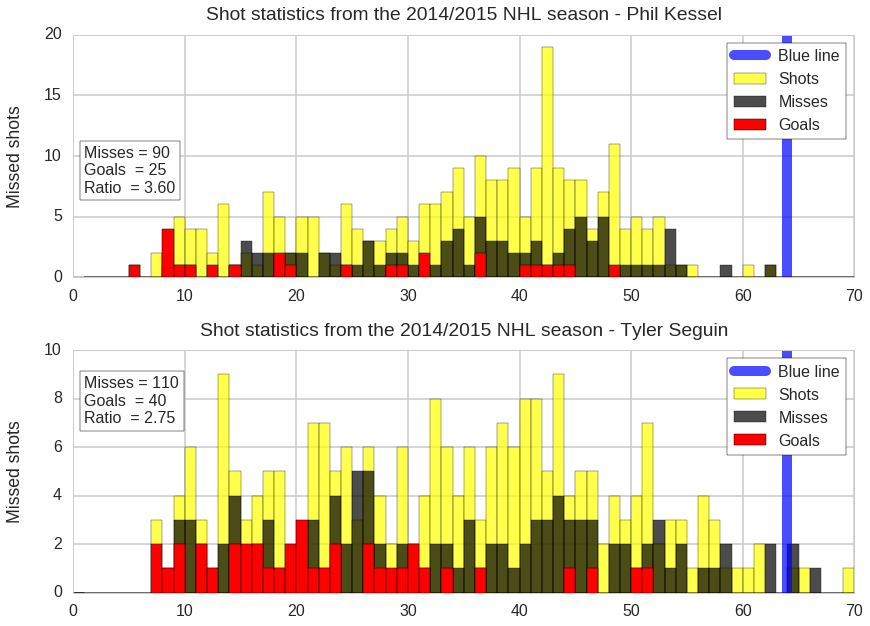

In [204]:
def plot_player(player, shots, misses, goals):
    plt.hist(shots, bins=np.arange(0,100,1), color='yellow', alpha=0.7, label='Shots')
    plt.hist(misses, bins=np.arange(0,100,1), color='black', alpha=0.7, label='Misses')
    plt.hist(goals, bins=np.arange(0,100,1), color='red', label='Goals')
    plt.title('Shot statistics from the 2014/2015 NHL season - '+player, y=1.04)
    plt.ylabel('Missed shots', labelpad=20)
    plt.xlim(0,70)

    box = dict(boxstyle='square', facecolor='white')
    plt.text(1, 7, # (x,y) position of text box
              'Misses = '+str(len(misses))+'\n'
             +'Goals  = '+str(len(goals))+'\n'
             +'Ratio  = %.2f'%(float(len(misses))/len(goals)),
             bbox=box, fontsize=16)

    plt.axvline(64,0,1000,color='b', label='Blue line', alpha=0.7, linewidth=10)

    legend = plt.legend(frameon=True)
    legend.get_frame().set_edgecolor('black')

    
plt.subplot(211)
plot_player('Phil Kessel', Kessel_shots, Kessel_misses, Kessel_goals)

plt.subplot(212)
plot_player('Tyler Seguin', Seguin_shots, Seguin_misses, Seguin_goals)
plt.ylim(0,10)

plt.subplots_adjust(hspace=0.3)

In [197]:
Phaneuf_shots = GetPlayerShots('3', 'TOR', '1')
Phaneuf_misses = GetPlayerShots('3', 'TOR', '7')
Phaneuf_goals = GetPlayerShots('3', 'TOR', '2')
print('shots =',Phaneuf_shots[:10])
print('misses =',Phaneuf_misses[:10])
print('goals =',Phaneuf_goals[:10])

('shots =', [29, 19, 45, 54, 57, 56, 54, 57, 25, 39])
('misses =', [59, 5, 63, 58, 18, 41, 51, 37, 57, 52])
('goals =', [59, 56, 42])


In [198]:
Karlsson_shots = GetPlayerShots('65', 'OTT', '1')
Karlsson_misses = GetPlayerShots('65', 'OTT', '7')
Karlsson_goals = GetPlayerShots('65', 'OTT', '2')
print('shots =',Karlsson_shots[:10])
print('misses =',Karlsson_misses[:10])
print('goals =',Karlsson_goals[:10])

('shots =', [65, 36, 35, 29, 44, 51, 50, 32, 54, 56])
('misses =', [47, 39, 48, 35, 43, 62, 31, 52, 42, 43])
('goals =', [26, 5, 21, 62, 60, 56, 24, 39, 27, 15])


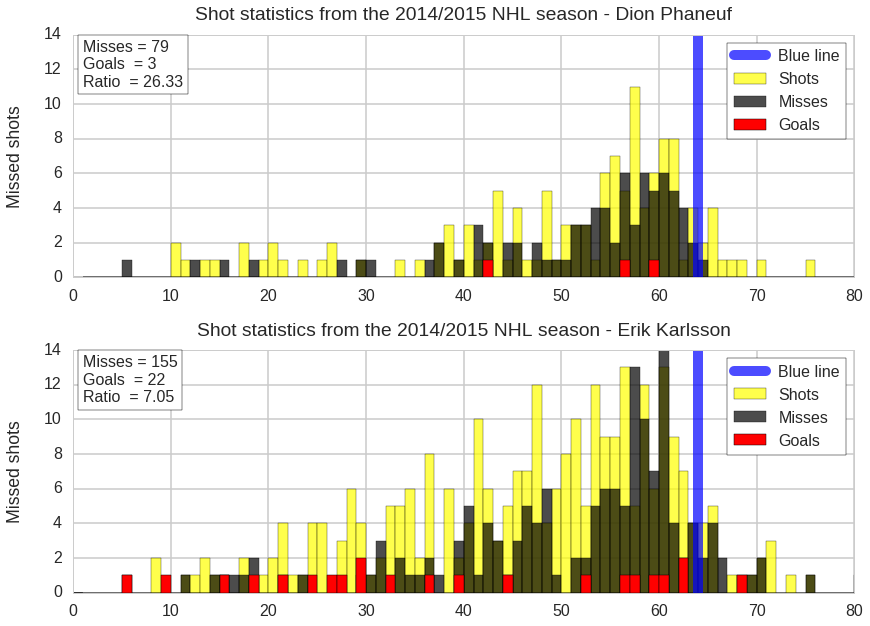

In [207]:
def plot_player(player, shots, misses, goals):
    plt.hist(shots, bins=np.arange(0,100,1), color='yellow', alpha=0.7, label='Shots')
    plt.hist(misses, bins=np.arange(0,100,1), color='black', alpha=0.7, label='Misses')
    plt.hist(goals, bins=np.arange(0,100,1), color='red', label='Goals')
    plt.title('Shot statistics from the 2014/2015 NHL season - '+player, y=1.04)
    plt.ylabel('Missed shots', labelpad=20)
    plt.xlim(0,80)
    plt.ylim(0,14)

    box = dict(boxstyle='square', facecolor='white')
    plt.text(1, 11, # (x,y) position of text box
              'Misses = '+str(len(misses))+'\n'
             +'Goals  = '+str(len(goals))+'\n'
             +'Ratio  = %.2f'%(float(len(misses))/len(goals)),
             bbox=box, fontsize=16)

    plt.axvline(64,0,1000,color='b', label='Blue line', alpha=0.7, linewidth=10)

    legend = plt.legend(frameon=True)
    legend.get_frame().set_edgecolor('black')

    
plt.subplot(211)
plot_player('Dion Phaneuf', Phaneuf_shots, Phaneuf_misses, Phaneuf_goals)

plt.subplot(212)
plot_player('Erik Karlsson', Karlsson_shots, Karlsson_misses, Karlsson_goals)

plt.subplots_adjust(hspace=0.3)

Now we'll filter shooting statistics for Toronto and compare to the rest of the league.

In [161]:
def TorStats(game):
    df = game.playbyplay
    df = df.loc[(df['Away Team'] == ' TOR ') | (df['Home Team'] == ' TOR'), ['Event','slot1']]
    return df
tor_shotdata = pd.concat(map(TorStats, games))

In [162]:
tor_miss_distances = [int(tor_shotdata.iloc[i,1]) for i in range(len(tor_shotdata))
                      if tor_shotdata.iloc[i,0] == '7']
print(len(tor_miss_distances))
tor_miss_distances[:10]

2064


[41, 19, 60, 22, 27, 26, 53, 57, 37, 50]

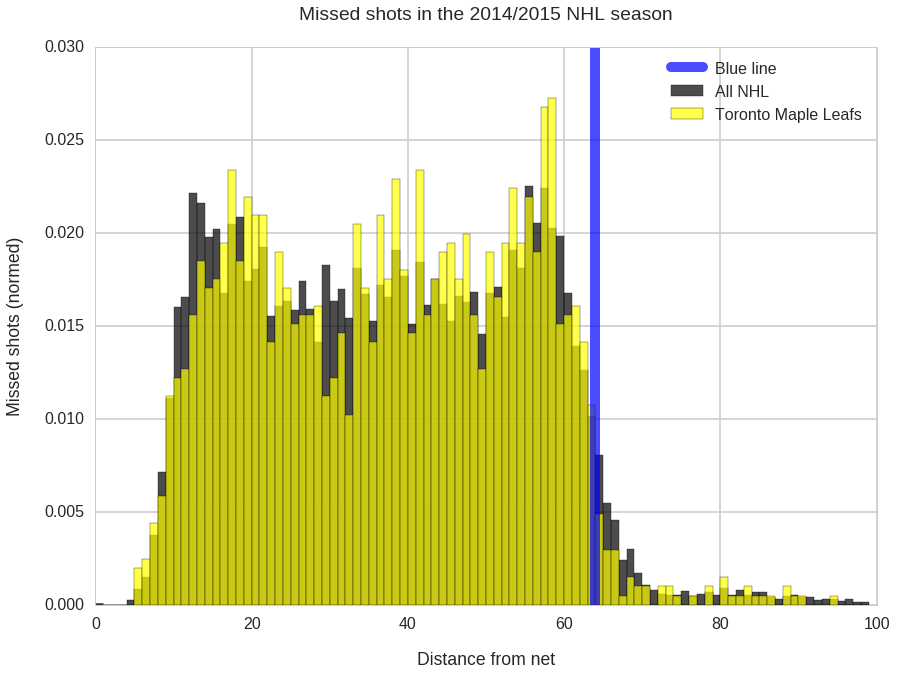

In [166]:
plt.hist(all_miss_distances, bins=np.arange(0,100,1), color='black', alpha=0.7, normed=True, label='All NHL')
plt.hist(tor_miss_distances, bins=np.arange(0,100,1), color='yellow', alpha=0.7, normed=True, label='Toronto Maple Leafs')
plt.title("Missed shots in the 2014/2015 NHL season", y=1.04)
plt.xlabel("Distance from net", labelpad=20)
plt.ylabel("Missed shots (normed)", labelpad=20)
plt.axvline(64,0,1000,color='b', label='Blue line', alpha=0.7, linewidth=10)
plt.legend()